##  EDA : Let's check out the data  

In [4]:
import Beer
from BeerScraper import create_data
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
from bs4 import BeautifulSoup
import requests
import re
import nltk

pd.set_option('max_colwidth', 300)

df = pd.read_csv('beer.csv', header='infer')
df_copy = df  #save a copy of dataframe for reference.  don't change this copy
df.head()

,name,brewery,style,rating,review
0,Big Rock Ale,Big Rock Brewery,Scottish Ale,3.90,"smell  soft hop aroma with significant malt scents. this one smells very creamy. taste  and creamy it is. the traditional irish flavors come out at the tongue. this is creamy, not like a cream ale, but close. the malt is big, buttery, and very smooth. the hops are very unique. this is not a sh..."
1,Flip Ale,Dogfish Head Craft Brewery,Old Ale,4.08,on tap at dfh rehoboth... collab with eatily... cardamom and red wine must. golden orange. .no head. typical dfh yeast aroma. ..some spice and maybe a belgian influence. sweet spicy and somewhat fruity.. not much old ale characteristic. too light for that. its still tasty. the cardamom does add...
2,The Almond Marzen Project - Beer Camp #26,Sierra Nevada Brewing Co.,Märzen / Oktoberfest,3.78,"nice auburn impressions, tons of clarity, solid inch of off white head. aroma was a little bit sweet and nutty. taste gave a little more sweetness, stayed away from hops and bitterness, relatively light bodied. nothing almond came out of it that was obvious. kind of a fancied up oktoberfest ..."
3,Perpetual Burn IPA,Rock Bottom Restaurant & Brewery,American IPA,3.88,"s - piney, a little cat piss in a good way, skunky bud. t - some caramel front, tons of hops at the finish. m - medium body, a little too sharp and unbalanced for me. d - very sessionable considering the hops and abv."
4,Hop Monster DRIPA,Iron Hill Brewery & Restaurant,American Double / Imperial IPA,4.14,"double red ipa, full-bodied rich caramel malt character with a generous amount of american hops. beware the monster! a: this was a clear, amber tinted copper color. it was served to me with a firm, frothy cap. s: sugar cookie/short bread malts with a little honey and a very strong blast of tro..."


In [5]:
# print the text of the first review:
print(df['review'][0])

smell  soft hop aroma with significant malt scents. this one smells very creamy. taste  and creamy it is. the traditional irish flavors come out at the tongue. this is creamy, not like a cream ale, but close. the malt is big, buttery, and very smooth. the hops are very unique. this is not a sharp hop flavor. this is an easy, saturated, well-mixed blend that plays a complimenting second fiddle to the malt base. no sweetness. the finish is nutty and big. this ale changes personalities at the end. mouthfeel  lightly carbonated and exceptionally smooth and creamy. drinkability  very creamy. i know that im repeating myself, but this ale is creamy like peanut butter. its actually kind of nutty to boot. creamy. 


###  REVIEWS: how many ratings have a review with words?  
Review is the text to describe the beer.  I need reviews with words.  
22% of reviews are blank.  About 10% are 1-10 characters long,  
About half of reviews are < 100 words.  

In [6]:
df['review'].describe()

count     80818
unique    42415
top            
freq      17624
Name: review, dtype: object

In [7]:
# An empty review is one blank space.
df['review'][7]

' '

In [8]:
df['review'][10]

' '

verbose reviews: 63,194
  blank reviews: 17,624
  total reviews: 80,818
blank reviews are 21.81% out of 80818 observations

CHART: top bar shows blank reviews, lower bar shows verbose reviews


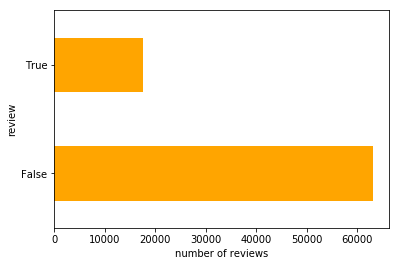

In [9]:
import matplotlib.pyplot as plt

#count the blank reviews and the non-blank (verbose) reviews
b = df.groupby([df['review']==' ']).size()
print('verbose reviews:', format(b[0], ',d'))
print('  blank reviews:', format(b[1], ',d'))
print('  total reviews:', format(len(df), ',d'))
print("blank reviews are {:.2f}% out of {} observations".format(100* b[1]/(b[1]+b[0]), b[1]+b[0]))

print('')
print('CHART: top bar shows blank reviews, lower bar shows verbose reviews')
_= b.plot(kind='barh', color='orange')
_= plt.xlabel('number of reviews')
plt.show()

17624
7625
2468
1428
814
18


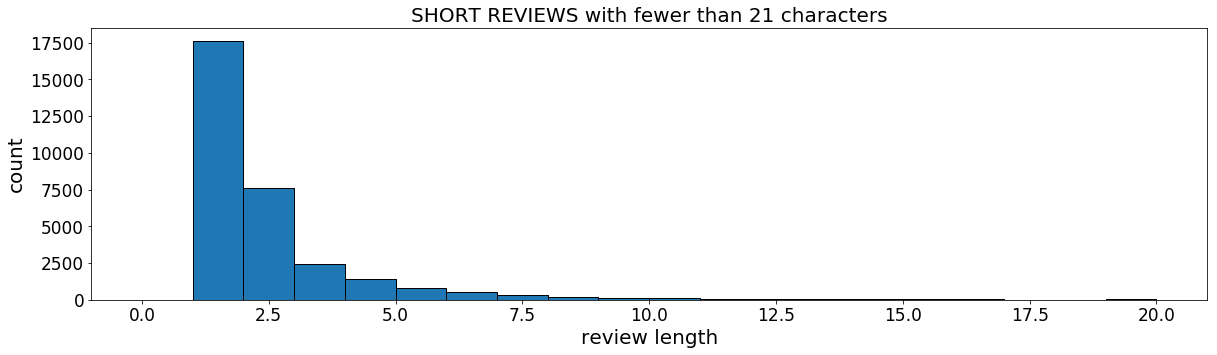

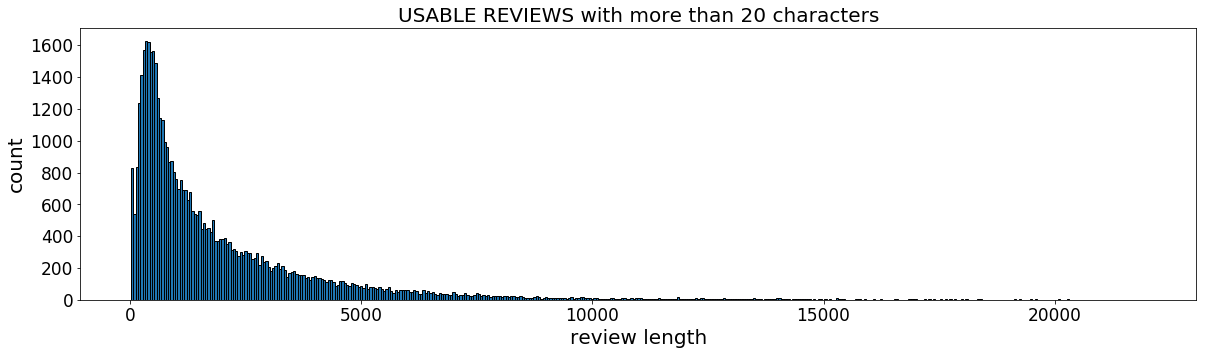

In [10]:
# review length distribution.  
# 
import matplotlib.pyplot as plt

# add a column that measures length of 'review'
df['review_length'] = df['review'].str.len()
print(sum(df['review_length']==1))
print(sum(df['review_length']==2))
print(sum(df['review_length']==3))
print(sum(df['review_length']==4))
print(sum(df['review_length']==5))
print(sum(df['review_length']==20))
max(df.review_length)

bins= np.arange(0,21,1)  
_= plt.figure(figsize=(20,5))
_= plt.hist(df['review_length'], bins=bins, edgecolor="k")
_= plt.xticks(size=17)
_= plt.yticks(size=17)
_= plt.title('SHORT REVIEWS with fewer than 21 characters', size=20)
_= plt.xlabel('review length', size=20)
_= plt.ylabel('count', size=20)
plt.show()

bins= np.arange(21,22000,50)  
_= plt.figure(figsize=(20,5))
_= plt.hist(df['review_length'], bins=bins, edgecolor="k")
_= plt.xticks(size=17)
_= plt.yticks(size=17)
_= plt.title('USABLE REVIEWS with more than 20 characters', size=20)
_= plt.xlabel('review length', size=20)
_= plt.ylabel('count', size=20)
plt.show()


In [11]:
# explore word length per review:
# only measure verbose reviews.  If review is blank, set length to the avg of the verbose reviews.

df['review_length'] = df['review'].apply(len)

# average word length
def avg_word_len(words):
    separate_words = words.split()
    count_words = (len(separate_words))    # number of words
    if count_words> 0:
        characters = len(words)  # length of text
        avg = (characters - count_words+1)/count_words
    else:
        avg = 5.13  # this is the mean of the verbose reviews    
    return avg   

df['avg_word_length'] = df['review'].apply(avg_word_len)

mean word length: 4.9266452222155666
review with shortest words: 2.0
review with longest words: 30.0
reviews avg word < 4.1: 679
reviews avg word > 5.7: 1074


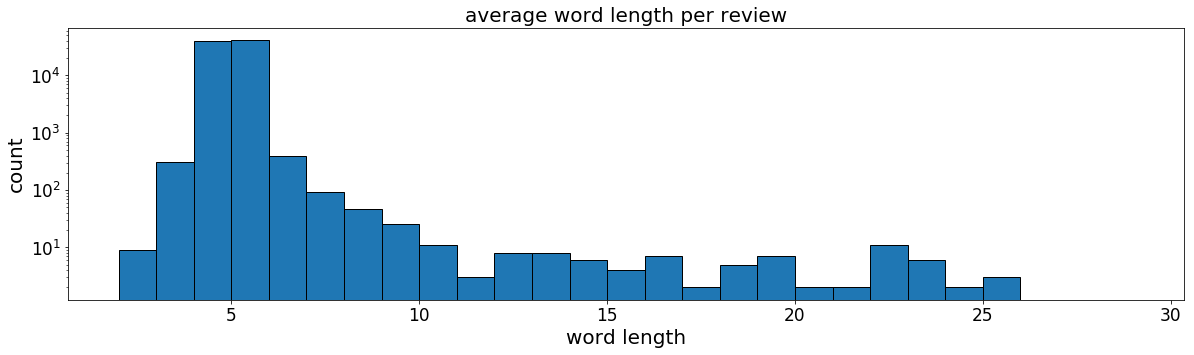

In [12]:
# histogram of average word length

print('mean word length:', np.mean(df['avg_word_length']))
print('review with shortest words:', np.min(df.avg_word_length))
print('review with longest words:', np.max(df.avg_word_length))
print('reviews avg word < 4.1:', sum(df.avg_word_length<4.1))
print('reviews avg word > 5.7:', sum(df.avg_word_length>5.7))

bins= np.arange(2,30,1)  
_= plt.figure(figsize=(20,5))
_= plt.yscale('log', nonposy='clip')
_= plt.hist(df['avg_word_length'], bins=bins, edgecolor="k")
_= plt.xticks(size=17)
_= plt.yticks(size=17)
_= plt.title('average word length per review', size=20)
_= plt.xlabel('word length', size=20)
_= plt.ylabel('count', size=20)
plt.show()

df original length 80818
length without short reviews 49141


/Users/brentmarijensen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


mean word length: 4.786481625707769
review with shortest words: 3.375
review with longest words: 30.0
reviews avg word < 4.1: 640
reviews avg word > 5.7: 988


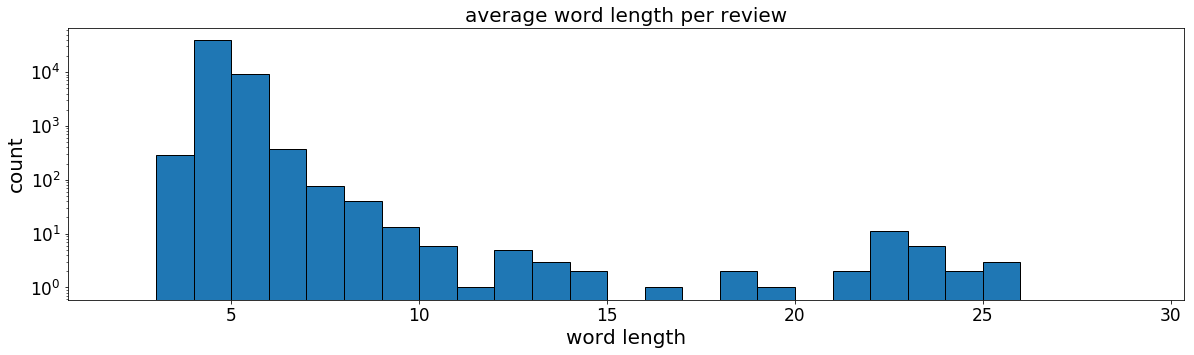

In [13]:
# Do the same analysis with usable (> 20 character) reviews

print('df original length',len(df))
# drop all reviews with < 20 characters
good_df = df[df['review'].map(len) > 20]
print('length without short reviews',len(good_df))

# reset dataframe index for the shortened dataframe
good_df['index'] = np.arange(len(good_df))
good_df = good_df.set_index('index')

print('mean word length:', np.mean(good_df['avg_word_length']))
print('review with shortest words:', np.min(good_df.avg_word_length))
print('review with longest words:', np.max(good_df.avg_word_length))
print('reviews avg word < 4.1:', sum(good_df.avg_word_length<4.1))
print('reviews avg word > 5.7:', sum(good_df.avg_word_length>5.7))

bins= np.arange(2,30,1)  
_= plt.figure(figsize=(20,5))
_= plt.yscale('log', nonposy='clip')
_= plt.hist(good_df['avg_word_length'], bins=bins, edgecolor="k")
_= plt.xticks(size=17)
_= plt.yticks(size=17)
_= plt.title('average word length per review', size=20)
_= plt.xlabel('word length', size=20)
_= plt.ylabel('count', size=20)
plt.show()

In [14]:
# find review with longest word length
def avg_word_len(words):
    separate_words = words.split()
    count_words = (len(separate_words))    # number of words
    avg = 0
    if count_words> 0:
        avg = sum(len(word) for word in separate_words)/len(separate_words)
    return float(avg)     

long_word_review = 'a b c'
avg_word = avg_word_len(long_word_review)
for idx, row in good_df.iterrows():
    if avg_word_len(long_word_review) < row.avg_word_length:
        long_word_review = row.review
                            
print('review with longest words', avg_word_len(long_word_review), 'avg length')
print('the review:',long_word_review)   


review with longest words 23.0 avg length
the review:  3.25/3.25/3.25/3.5/3.25 


reviews with very long avg word length are not interesting.  Mostly strings of digits.  In analysis, I'll strip numbers, so these will be gone.  

In [15]:
long_word_df = df[df['avg_word_length']>15]
print(len(long_word_df))
print(long_word_df['review'])

49
476                          4/4.25/4.25/4/4.25 
2781                         4/3.5/3.5/3.75/3.5 
6128                    3.25/3.25/3.25/3.5/3.25 
13383                     3.75/4/3.75/3.75/3.75 
15964                very flavorful.            
16762                   2.75/3.25/3.5/3.25/3.25 
17723                           3.75/4/3.75/4/4 
23377                    4/3.25/3.25/3.75/3.25  
23569                     3.75/3.5/3.5/3.75/3.5 
24772                              outstanding! 
24993                        10-24              
25884                     3.75/3.5/3.75/3.5/3.5 
26775                                   12-10   
27239                     3.25/3.5/3.5/3.25/3.5 
33874          flashback #144                   
37783                    3.75/2.5/2.25/2.75/2.5 
39965                         3.75/3.25/2.5/3/3 
40034                    3.5/3.25/3.25/3.5/3.25 
41231                        4/4/3.75/3.75/3.75 
41404                        3.75/4.25/4.25/4/4 
41742            

In [16]:
# print the shortest reviews, with > 1 char and < 20 chars

short_reviews = df[df['review'].str.len()<20]
print(len(short_reviews))
print(type(short_reviews))
full = ''
for r in short_reviews['review']:
    full = full + r
print(full[:1800])

31659
<class 'pandas.core.frame.DataFrame'>
                                                                                                                                                                                                                                                                                                                                                                                               4/4.25/4.25/4/4.25                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     eric                                                                  

In [17]:
print('short review count:', len(short_reviews))
short_reviews.head(10)

short review count: 31659


,name,brewery,style,rating,review,review_length,avg_word_length
7,Comet Dust,Equinox Brewing Company,American Pale Wheat Ale,3.00,,1,5.13
9,Wild Gift,Burning Sky Brewery,Berliner Weissbier,3.66,,3,5.13
10,UncALT Four Altbier,Call to Arms Brewing Company,Altbier,3.41,,1,5.13
13,Summer In Germany,Bosque Brewing Co.,Kölsch,3.51,,1,5.13
14,Murk Du Soleil,The Marble Arch,American Double / Imperial IPA,4.12,,1,5.13
15,3rd Base Imperial IPA,Siren's Tasting Room / Blue Lightning Brew,American Double / Imperial IPA,3.56,,2,5.13
18,7-Spoke Stout,Flying Bike Cooperative Brewery,American Stout,3.99,,1,5.13
20,2nd Anniversary Ale,Alpine Dog Brewing Company,Russian Imperial Stout,4.31,,4,5.13
21,La Noire,Brasserie Corrézienne,English Porter,3.59,,1,5.13
22,J. Wakefield / New Belgium Grilled Pineapple Berliner Weiss,J. Wakefield Brewing,Berliner Weissbier,3.96,,6,5.13


### STYLES: count how many styles, and how many reviews of each style  
Counting styles revealed several things:  
First, 104 styles is a big number!  I would have guessed fewer.  
I confirmed on the BA.com site; they list 104 beer styles.
Secondly, some had NaN count.  Scanning the names, they all appear to be uncommon styles.  My random scraping did not find any of these.
Next, many styles had only 1 review.  Some had very few reviews.  
I won't be able to analyze these beers.  
But the majority of styles had over 200 reviews per style.  
(Some style names seem similar, such as American IPA and Imperial IPA and English IPA.  I might want to combine them.)  
American IPA, with 6706/55,243 reviews is far and away the most popular!  


In [18]:
df['style'].describe()

count            80818
unique             104
top       American IPA
freq              9758
Name: style, dtype: object

In [19]:
# how many STYLES are represented

styles = df.groupby(['style']).size()  
print('number of styles reviewed:',len(styles))

number of styles reviewed: 104


In [20]:
labels = df.groupby(['style']).size() 
big_styles = labels[labels>150]
print('Number of styles with over 150 reviews:', len(big_styles))
print('')
print(big_styles.sort_values(ascending=False))

Number of styles with over 150 reviews: 85

style
American IPA                          9758
American Pale Ale (APA)               4877
American Double / Imperial IPA        4100
Saison / Farmhouse Ale                4090
American Wild Ale                     2928
American Porter                       2681
American Double / Imperial Stout      2465
American Amber / Red Ale              2365
American Stout                        2114
Fruit / Vegetable Beer                1740
American Brown Ale                    1647
American Blonde Ale                   1427
Hefeweizen                            1283
Witbier                               1235
Belgian Pale Ale                      1224
American Pale Wheat Ale               1117
German Pilsener                       1082
Russian Imperial Stout                1060
Berliner Weissbier                    1030
American Black Ale                     986
English Bitter                         958
Milk / Sweet Stout                     927
Engl

In [21]:
type(big_styles)

pandas.core.series.Series

In [22]:
print(big_styles.index)

Index(['Altbier', 'American Adjunct Lager', 'American Amber / Red Ale',
       'American Amber / Red Lager', 'American Barleywine',
       'American Black Ale', 'American Blonde Ale', 'American Brown Ale',
       'American Double / Imperial IPA', 'American Double / Imperial Pilsner',
       'American Double / Imperial Stout', 'American IPA',
       'American Pale Ale (APA)', 'American Pale Lager',
       'American Pale Wheat Ale', 'American Porter', 'American Stout',
       'American Strong Ale', 'American Wild Ale', 'Baltic Porter',
       'Belgian Dark Ale', 'Belgian IPA', 'Belgian Pale Ale',
       'Belgian Strong Dark Ale', 'Belgian Strong Pale Ale',
       'Berliner Weissbier', 'Bière de Garde', 'Bock',
       'California Common / Steam Beer', 'Chile Beer', 'Cream Ale',
       'Czech Pilsener', 'Doppelbock', 'Dortmunder / Export Lager', 'Dubbel',
       'Dunkelweizen', 'English Barleywine', 'English Bitter',
       'English Brown Ale', 'English Dark Mild Ale',
       'English Indi

In [23]:
labels = df.groupby(['style']).size() 
small_styles = labels[labels<150]
print('Number of styles with fewer than 150 reviews:', len(small_styles))
print('')
print(small_styles.index)

Number of styles with fewer than 150 reviews: 19

Index(['American Dark Wheat Ale', 'American Malt Liquor',
       'Bière de Champagne / Bière Brut', 'Black & Tan', 'Braggot', 'Eisbock',
       'English Pale Mild Ale', 'Euro Strong Lager', 'Faro', 'Gueuze',
       'Happoshu', 'Japanese Rice Lager', 'Kristalweizen', 'Kvass',
       'Lambic - Unblended', 'Low Alcohol Beer', 'Roggenbier', 'Sahti',
       'Scottish Gruit / Ancient Herbed Ale'],
      dtype='object', name='style')


In [24]:
labels = df.groupby(['style']).size() 
small_styles = labels[labels<150]
print('Number of styles with fewer than 150 reviews:', len(small_styles))
print('')
print(small_styles)

Number of styles with fewer than 150 reviews: 19

style
American Dark Wheat Ale                 92
American Malt Liquor                   109
Bière de Champagne / Bière Brut         17
Black & Tan                             42
Braggot                                103
Eisbock                                 45
English Pale Mild Ale                  120
Euro Strong Lager                      130
Faro                                     9
Gueuze                                  59
Happoshu                                40
Japanese Rice Lager                     42
Kristalweizen                           85
Kvass                                   50
Lambic - Unblended                      57
Low Alcohol Beer                       123
Roggenbier                              84
Sahti                                   18
Scottish Gruit / Ancient Herbed Ale    118
dtype: int64


These styles are uncommon.  I may want to remove them from my list, as I won't have enough data to predict these styles.  (Too bad; I like Gueze.)

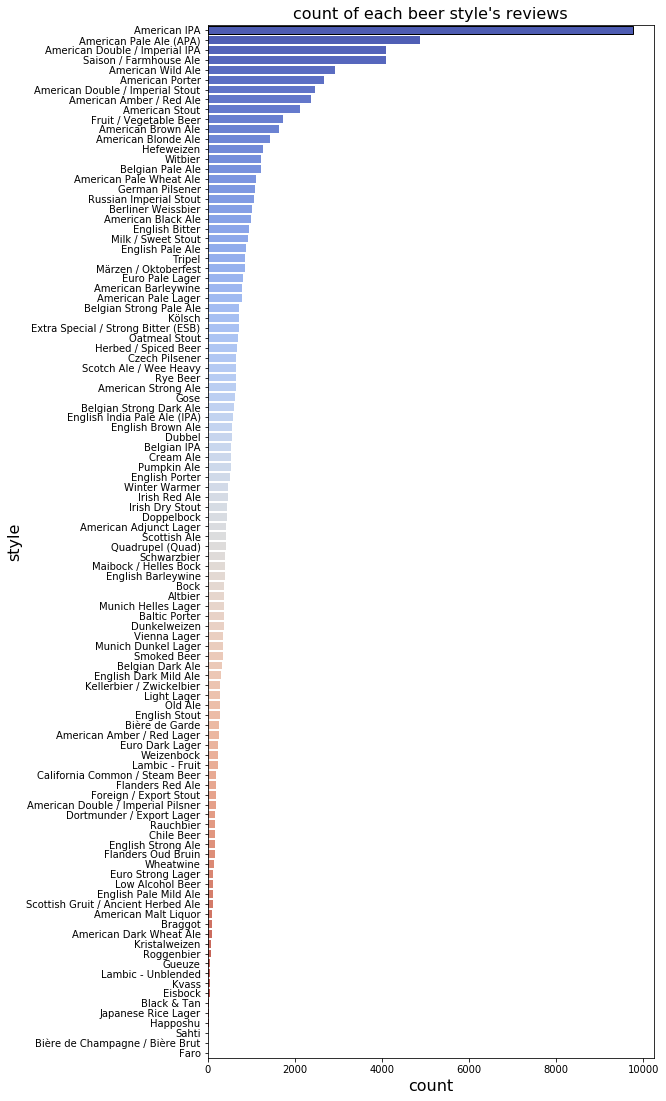

In [25]:
import seaborn as sns
styles = pd.DataFrame()
labels = df.groupby(['style']).size() 
styles['count'] = labels
styles['style'] = labels.index
styles = styles.sort_values(by='count', ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(8,19)
sns.barplot(x='count', y='style', data=styles, ax=ax, palette="coolwarm", edgecolor="k")
plt.title("count of each beer style's reviews", size=16)
plt.ylabel('style', size=16)
plt.xlabel('count', size=16)
plt.show()

In [26]:
# COMBINE SIMILAR STYLES OF BEER.  

df['style'].replace('Saison / Farmhouse Ale', 'Farm Ale', inplace=True)
df['style'].replace('Bière de Garde', 'Farm Ale', inplace=True)
df['style'].replace('American IPA', 'IPA', inplace=True)
df['style'].replace('English India Pale Ale (IPA)', 'IPA', inplace=True)
df['style'].replace('Belgian IPA', 'IPA', inplace=True)
df['style'].replace('Scotch Ale / Wee Heavy', 'Scottish Ale', inplace=True)
df['style'].replace('American Pale Ale (APA)', 'Pale Ale', inplace=True)
df['style'].replace('English Pale Ale', 'Pale Ale', inplace=True)
df['style'].replace('Belgian Pale Ale', 'Pale Ale', inplace=True)
df['style'].replace('American Brown Ale', 'Brown Ale', inplace=True)
df['style'].replace('English Brown Ale', 'Brown Ale', inplace=True)
df['style'].replace('English Dark Mild Ale', 'Brown Ale', inplace=True)
df['style'].replace('American Stout', 'Stout', inplace=True)
df['style'].replace('English Stout', 'Stout', inplace=True)
df['style'].replace('Milk / Sweet Stout', 'Stout', inplace=True)
df['style'].replace('Oatmeal Stout', 'Stout', inplace=True)
df['style'].replace('Oatmeal Stout', 'Stout', inplace=True)
df['style'].replace('American Double / Imperial Stout', 'Imperial Stout', inplace=True)
df['style'].replace('Russian Imperial', 'Imperial Stout', inplace=True)
df['style'].replace('American Porter', 'Porter', inplace=True)
df['style'].replace('Baltic Porter', 'Porter', inplace=True)
df['style'].replace('English Porter', 'Porter', inplace=True)
df['style'].replace('American Amber / Red Lager', 'Lager', inplace=True)
df['style'].replace('Vienna Lager', 'Lager', inplace=True)
df['style'].replace('German Pilsener', 'Lager', inplace=True)
df['style'].replace('Munich Helles Lager', 'Lager', inplace=True)
df['style'].replace('American Adjunct Lager', 'American Lager', inplace=True)
df['style'].replace('American Pale Lager', 'American Lager', inplace=True)
df['style'].replace('American Barleywine', 'Barleywine', inplace=True)
df['style'].replace('English Barleywine', 'Barleywine', inplace=True)
df['style'].replace('English Bitter', 'Bitter', inplace=True)
df['style'].replace('Extra Special / Strong Bitter (ESB)', 'Bitter', inplace=True)
df['style'].replace('American Pale Wheat Ale', 'Wheat', inplace=True)
df['style'].replace('Witbier', 'Wheat', inplace=True)
#df['style'].replace('Witbier', 'Wheat', inplace=True)


# remove uncommon styles (in EDA, I found 13 styles with fewer than 60 reviews)
#uncommon = [ 'American Dark Wheat Ale','Bière de Champagne / Bière Brut', 'Black & Tan', 
#            'Eisbock', 'Faro', 'Gueuze', 'Happoshu', 'Japanese Rice Lager', 'Kristalweizen',
#            'Kvass', 'Lambic - Unblended','Roggenbier', 'Sahti' ]   
labels = df.groupby(['style']).size() 
uncommon = labels[labels<160]
df = df.loc[~df['style'].isin(uncommon.index)]
print('length without uncommon styles',len(df))

length without uncommon styles 79320


In [27]:
print(len(uncommon), 'styles excluded:')
print(uncommon.index)

20 styles excluded:
Index(['American Dark Wheat Ale', 'American Malt Liquor',
       'Bière de Champagne / Bière Brut', 'Black & Tan', 'Braggot', 'Eisbock',
       'English Pale Mild Ale', 'Euro Strong Lager', 'Faro', 'Gueuze',
       'Happoshu', 'Japanese Rice Lager', 'Kristalweizen', 'Kvass',
       'Lambic - Unblended', 'Low Alcohol Beer', 'Roggenbier', 'Sahti',
       'Scottish Gruit / Ancient Herbed Ale', 'Wheatwine'],
      dtype='object', name='style')


In [28]:
labels.IPA

10877

In [29]:
labels = df.groupby(['style']).size()
print(labels.sort_values(ascending=False))

style
IPA                                   10877
Pale Ale                               6987
Farm Ale                               4359
American Double / Imperial IPA         4100
Stout                                  4037
Porter                                 3571
American Wild Ale                      2928
Brown Ale                              2518
Imperial Stout                         2465
American Amber / Red Ale               2365
Wheat                                  2352
Lager                                  2071
Fruit / Vegetable Beer                 1740
Bitter                                 1673
American Blonde Ale                    1427
Hefeweizen                             1283
American Lager                         1226
Barleywine                             1190
Scottish Ale                           1079
Russian Imperial Stout                 1060
Berliner Weissbier                     1030
American Black Ale                      986
Tripel                    

In [30]:
print('percent of beers in IPA style:', labels.IPA/len(df))

percent of beers in IPA style: 0.137128088754


In [31]:
styles = df.groupby(['style']).size() 
print('Number of styles used:', len(styles))
print('')
print(styles.index)

Number of styles used: 64

Index(['Altbier', 'American Amber / Red Ale', 'American Black Ale',
       'American Blonde Ale', 'American Double / Imperial IPA',
       'American Double / Imperial Pilsner', 'American Lager',
       'American Strong Ale', 'American Wild Ale', 'Barleywine',
       'Belgian Dark Ale', 'Belgian Strong Dark Ale',
       'Belgian Strong Pale Ale', 'Berliner Weissbier', 'Bitter', 'Bock',
       'Brown Ale', 'California Common / Steam Beer', 'Chile Beer',
       'Cream Ale', 'Czech Pilsener', 'Doppelbock',
       'Dortmunder / Export Lager', 'Dubbel', 'Dunkelweizen',
       'English Strong Ale', 'Euro Dark Lager', 'Euro Pale Lager', 'Farm Ale',
       'Flanders Oud Bruin', 'Flanders Red Ale', 'Foreign / Export Stout',
       'Fruit / Vegetable Beer', 'Gose', 'Hefeweizen', 'Herbed / Spiced Beer',
       'IPA', 'Imperial Stout', 'Irish Dry Stout', 'Irish Red Ale',
       'Kellerbier / Zwickelbier', 'Kölsch', 'Lager', 'Lambic - Fruit',
       'Light Lager', 'Maibock

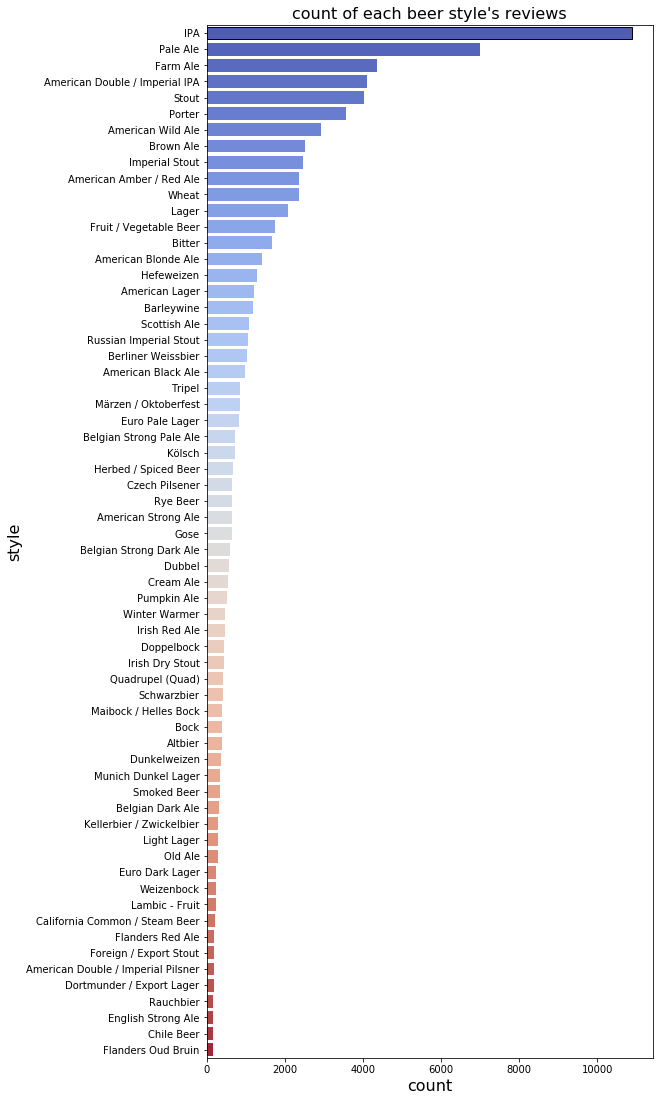

In [32]:
import seaborn as sns
styles = pd.DataFrame()
labels = df.groupby(['style']).size() 
styles['count'] = labels
styles['style'] = labels.index
styles = styles.sort_values(by='count', ascending=False)
fig, ax = plt.subplots()
fig.set_size_inches(8,19)
sns.barplot(x='count', y='style', data=styles, ax=ax, palette="coolwarm", edgecolor="k")
plt.title("count of each beer style's reviews", size=16)
plt.ylabel('style', size=16)
plt.xlabel('count', size=16)
plt.show()

### RATINGS distribution  
Beers are rated on a scale of 1 to 5.  Ratings are averaged, so a rating can be anywhere in between.  
Check that no ratings exist >5 or <1.  
Plot a chart to see its shape.

In [53]:
df['review'].describe()

count     80818
unique    42415
top            
freq      17624
Name: review, dtype: object

In [54]:
meanrating= df.rating.mean()
print('mean rating: {:.2f}'.format(meanrating))
SDrating= df.rating.std()
print('standard deviation: {:.4f}'.format(SDrating))
print('median rating:', df.rating.median())
print('lowest rating:', df.rating.min())
print('highest rating:', df.rating.max())

mean rating: 3.73
standard deviation: 0.4588
median rating: 3.79
lowest rating: 1.0
highest rating: 5.0


In [ ]:
#   this is from danielhnyk.cz : 
#   I may use this to create a normal curve over the ratings dist

# create some normal random noisy data
ser = 50*np.random.rand() * np.random.normal(10, 10, 100) + 20

# plot normed histogram
plt.hist(ser, normed=True)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(ser))

# lets try the normal distribution first
m, s = stats.norm.fit(ser) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it

# exactly same as above
ag,bg,cg = stats.gamma.fit(ser)  
pdf_gamma = stats.gamma.pdf(lnspc, ag, bg,cg)  
plt.plot(lnspc, pdf_gamma, label="Gamma")

# guess what :) 
ab,bb,cb,db = stats.beta.fit(ser)  
pdf_beta = stats.beta.pdf(lnspc, ab, bb,cb, db)  
plt.plot(lnspc, pdf_beta, label="Beta")

plt.show()  

mean rating: 3.73
standard deviation: 0.4588
median rating: 3.79


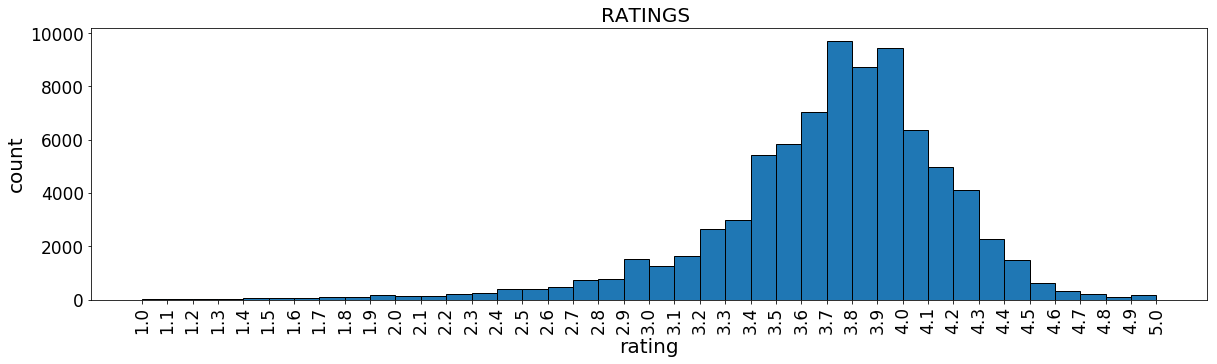

In [59]:
# ratings distribution.  
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

bins= np.arange(1,5.1,0.1)   # bins from 1 to 5, increments of 0.1
_= plt.figure(figsize=(20,5))
_= plt.hist(df['rating'], bins=bins, edgecolor="k") #
_= plt.xticks(bins, rotation='vertical',size=17)
_= plt.yticks(size=17)
_= plt.title('RATINGS ', size=20)
_= plt.xlabel('rating', size=20)
_= plt.ylabel('count', size=20)

meanrating= df.rating.mean()
print('mean rating: {:.2f}'.format(meanrating))
SDrating= df.rating.std()
print('standard deviation: {:.4f}'.format(SDrating))
print('median rating:', df.rating.median())

### BREWERIES  
count number of reviews from each brewery  
I don't know if brewery will be significant.  
Rock Bottom and Tired Hands had over 300 reviews each!  (and I've never heard of them.)  
The majority had 1 review.  

In [60]:
df['brewery'].describe()

count                                80818
unique                               10817
top       Rock Bottom Restaurant & Brewery
freq                                   391
Name: brewery, dtype: object

In [61]:
# examine distribution of brewerits

breweries = df.brewery.value_counts()
print('number of breweries reviewed:',len(breweries))
print('breweries with only 1 review:',sum(breweries==1))
print('breweries with 2 or 3 reviews:', sum(breweries==2)+sum(breweries==3))
print('')
print(breweries[breweries>70])


number of breweries reviewed: 10817
breweries with only 1 review: 2612
breweries with 2 or 3 reviews: 2919

Rock Bottom Restaurant & Brewery                   391
Tired Hands Brewing Company                        320
Cigar City Brewing                                 289
Goose Island Beer Co.                              235
Iron Hill Brewery & Restaurant                     228
Mikkeller ApS                                      221
The Bruery                                         185
Pizza Port Solana Beach                            183
Stone Brewing                                      180
Imperial Oak Brewing                               172
Sierra Nevada Brewing Co.                          165
Minneapolis Town Hall Brewery                      155
Wicked Weed Brewing                                139
Captain Lawrence Brewing Co.                       138
Al's of Hampden / Pizza Boy Brewing                137
Founders Brewing Company                           135
Short's Brew

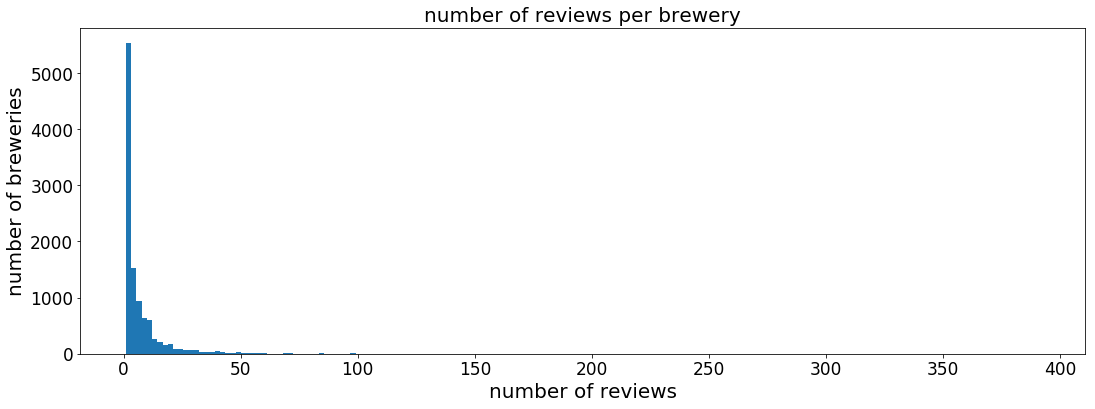

In [62]:
#_= breweries.hist(bins=175)
_= plt.figure(figsize=(18,6))
_= plt.hist(breweries, bins=175)
_= plt.xticks(size=17)
_= plt.yticks(size=17)
_= plt.title('number of reviews per brewery', size=20)
_= plt.xlabel('number of reviews', size=20)
_= plt.ylabel('number of breweries', size=20)
plt.show()

### NAMES  
The name might not matter, but let's look anyway.  
Some have very short names, some of which are errors ('IPA' and 'ESB' are styles.  'y', 'A', 'Te' are unlikely names, as are '15', '484', '6IX'.)  

In [63]:
df['name'].describe()

count           80818
unique          62957
top       Oktoberfest
freq              176
Name: name, dtype: object

In [64]:
short_names = df[df['name'].str.len()<4]
print(len(short_names))
print(type(short_names))
full = ''
for n in short_names['name']:
    full = full + n + ' '
print(full)

527
<class 'pandas.core.frame.DataFrame'>
TPA WPA Dig IPA ESB ESB SSS ESB ESB 6IX IPA ESB 26° Eis 15 IPA War Due BRU ESB Nüa Te Job IPA IPA IPA ESB IPA IPA IPA IPL IPA IPA 16 Wax One H2 KP 6 FAO IPA IPA ESB CLT 484 IPA 2IC C-4 Amy ESB ALT ESB IPA Oi Red NWA PDT OM Eve Bae Red Tux IPA 001 Glo IPA IPA POD ESB IPA IBA Ava Ann IPA IPL Id Wit ESB ESB III IPA IPA 12° IPA Ale OG One IPA Vor MO IPA IPA IPA IPA IPA IPA ESB IPA 710 TCM Eva MSB H3 ESB M CCC 360 331 CO2 IPA IPA IPA APA ESB IPA Red EPA V6 IPA ESB Hex IPA XPA ESB Alt Wor 3S IPA Red Vit IPA IPA IPA Alt H2 ESB Vos Alt Hey B Ale 26° PCP IPA Alt IPA IPA APA IPA ALT ESB Wit SRV IRA 724 ESB BAT POG ! IPL IPA Ale NWA L IPA IPA IPA 4 IPA ESB XXV IPA D Nut ESB S23 PSA IPA IPK IPK LSD Rot IPA DTF IPA IPA IPA IPA ESB IPA IPA Gui ESB 484 ESB BÁN #69 IPA IPA Edo IPA ESB Maz Mel SSR Joy IPA Hef idl ESB IPA APA IP1 Syl KSA PMX #9 ESB ESB TBA 484 JPA Ava APA Red IPA ESB ESB RAD ESB GFF NWA Fog Rot IPA IPA 555 ESB IPA Ten IPA TKO 4GA 2x4 PG Ale XSA 

IndexError: index 9 is out of bounds for axis 0 with size 9

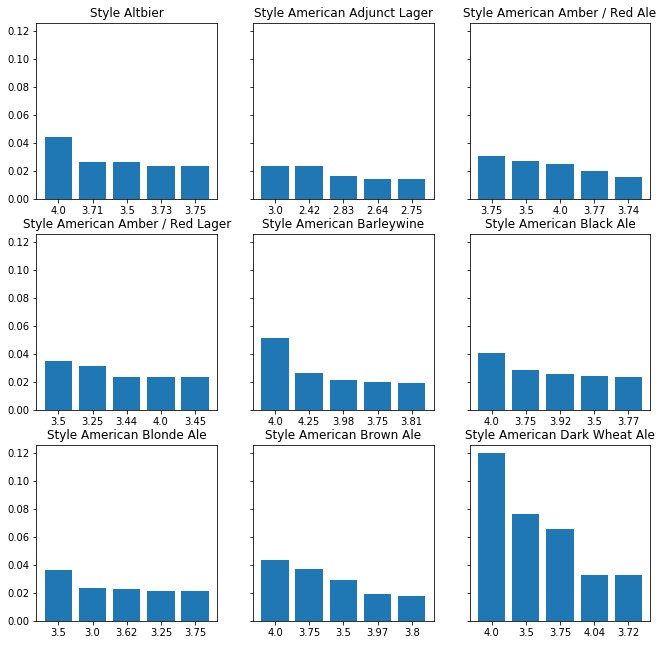

In [65]:
# OK this idea was cool, but half baked.  
# Show a grid of charts comparing ratings for some of the styles.
# look at this later if time permits.
# 1. use only 9 styles.  2. rating is continuous, not discrete.

fig, axes = plt.subplots(nrows=3, ncols=3, sharey= True, figsize=(11,11))
def normalize_group(x):  #for better comparison
    label, repetition = x.index, x
    t= sum(repetition)
    r = [n/t for n in repetition]
    return label, r
for idx, g in enumerate(df.groupby('style')):
    label, val = normalize_group(g[1]['rating'].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5], tick_label = label[:5])
    ax.set_title('Style {}'.format(g[0]))
fig.tight_layout